<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2024TeamA/blob/main/4_create_factsheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

## Import necessary packages and mount to drive

In [2]:
# !pip3 install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
# import pandas_profiling
# from datetime import datetime
# import re
import seaborn as sns
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
# will make plot outputs appear and stored within the notebook.
%matplotlib inline
from sqlite3 import Error
import folium
from folium import plugins

from google.colab import drive
drive.mount('/content/drive')

# Path
material_path = "/content/drive/MyDrive/M3_DM_GrpA"

# path of datawarehouse
DB_DWH_PATH = material_path + f"/DWH_MAPCOV.db"

dwh_db = sqlite3.connect(DB_DWH_PATH)
dwh_cursor = dwh_db.cursor()

Mounted at /content/drive


## Set and use filter for Covid-19 in relevant tables

Conditions: Filter nach Conditions, die parallel zu COVID aufgetreten sind.  
Erster Part enthält den allgemeien Filter in der Conditions Tabelle nach Start und Stop von COVID-19.  
Danach Merge mit der Conditions Tabelle OHNE 'COVID-19'. Das Ergebnis ist, dass hinter jedem Condition das Start/Stop Date von COVID steht. Nun kann eine Abfrage (Query) geschrieben werden, die die Datumsangaben vergleicht und filtert.

In [3]:
df_conditions_filter = pd.read_sql_query("SELECT START AS stdt_covid, STOP AS endt_covid, PATIENT FROM conditions_INFO WHERE DESCRIPTION = 'COVID-19'", dwh_db)
print("Patients with Covid:", df_conditions_filter.shape)
df_cond_other = pd.read_sql_query("SELECT START, STOP, PATIENT, DESCRIPTION FROM conditions_info WHERE DESCRIPTION NOT LIKE '%COVID%'", dwh_db)
print("Number of other conitons than Covid:",df_cond_other.shape)
df_cond_covid = pd.merge(df_cond_other, df_conditions_filter, left_on="PATIENT", right_on="PATIENT",how="inner")
print("Merge:",df_cond_covid.shape)
df_cond_covid_qry = df_cond_covid.query('(STOP >= stdt_covid or STOP == "") and (START <= endt_covid or endt_covid == "") and DESCRIPTION.str.contains("(disorder)")')
print("Filter for cond within the same time as COVID:",df_cond_covid_qry.shape)
# df_cond_covid_qry.head()
df_cond_grp = df_cond_covid_qry.groupby("PATIENT")["DESCRIPTION"].count().rename("Disorder")
print(df_cond_grp)

# Alternativ: Lists the unique vlaues of the column 'DESCRIPTION'
# df_cond_covid_qry.DESCRIPTION.unique()

Patients with Covid: (865, 3)
Number of other conitons than Covid: (4605, 4)
Merge: (4361, 6)
Filter for cond within the same time as COVID: (518, 6)
PATIENT
00680fcd-0ef2-99c5-f69d-59463206750f    4
00ff2a47-af82-8681-cb1d-428471df02f0    2
02b3eaaa-eaca-9497-b7fd-0f5eac551b95    3
03969e0b-c3f4-d792-026f-7dbbfbd36192    4
08d17744-57ec-4543-630c-65714c52505d    3
                                       ..
f0ccab99-7054-29cc-bb71-c15304d03e9a    3
f3b0e643-97e4-a25e-1837-827ae4a10c8b    4
f9c42e80-74f4-f5d0-342d-cf99088d3258    3
fe611f03-fd75-3047-b9e6-e673046706b5    3
ffd905f3-45fb-b2a7-7429-bf864ef29d81    2
Name: Disorder, Length: 129, dtype: int64


<ipython-input-3-0fcf0c9c0753>:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_cond_covid_qry = df_cond_covid.query('(STOP >= stdt_covid or STOP == "") and (START <= endt_covid or endt_covid == "") and DESCRIPTION.str.contains("(disorder)")')


Abfrage in devices_info nach zeitgleichem Auftreten mit COVID

In [4]:
df_dev_all = pd.read_sql_query("SELECT Patient, START, STOP, DESCRIPTION FROM devices_INFO WHERE DESCRIPTION = 'Mechanical ventilator (physical object)'", dwh_db)
df_dev_covid = pd.merge(df_dev_all, df_conditions_filter, left_on="PATIENT", right_on="PATIENT",how="inner")
print("Merge:",df_dev_covid.shape)
df_dev_covid_qry = df_dev_covid.query('(STOP >= stdt_covid or STOP == "") and (START <= endt_covid or endt_covid == "")')
print("Query:",df_dev_covid_qry.shape)
# print(df_dev_covid_qry)
df_dev_grp = df_dev_covid_qry.groupby("PATIENT")["DESCRIPTION"].count().rename("Ventilation")
print(df_dev_grp)

Merge: (20, 6)
Query: (20, 6)
PATIENT
12f8384e-d49a-1343-2e3a-dc547629d770    1
15905260-4510-3a9a-53b3-88a440c2128d    1
20604c29-ee90-6073-13f4-df3678392fc7    1
26013d81-a7ee-43dc-9678-abee01e3d3c4    1
26d353df-e9af-35b0-b694-af604d610bd9    1
3845c8f4-39c6-eeec-75e6-2780169f0aa3    1
6008a677-9edd-5ffc-699f-c32a109ffabd    1
63576001-7584-d85a-e056-475fe720a291    1
68a2bbc6-3f56-081e-3fd5-cbd13248ed31    1
69ba11d9-8061-f328-0733-ab332742c586    1
6a59c578-ebb4-e0bb-0b82-d5c57d5e9f2a    1
8a84c9b4-0ee2-8cd0-a78b-ed8e8d654467    1
8d49cb05-b1c3-b8fe-dc75-e43ad861f074    1
8ed0433d-4132-98f9-65b4-d5e06b8feffc    1
92df158a-bcb4-01af-1529-adf33db69253    1
adcc96d4-285a-e833-f968-13a940c78098    1
b228751b-8384-9070-a49c-faa67070f494    1
b56193a1-5bfb-bb37-0886-9a02d10edd41    1
bec7fd7c-d645-1450-f851-e21e07c2a442    1
de5013bd-4eb1-8e08-e863-c0ee3a03d6ca    1
Name: Ventilation, dtype: int64


Abfrage in medications_info nach zeitgleichem Auftreten mit COVID

In [5]:
df_med_all = pd.read_sql_query("SELECT Patient, START, STOP, DESCRIPTION, REASONDESCRIPTION FROM medications_info WHERE REASONDESCRIPTION = 'COVID-19'", dwh_db)
df_med_covid = pd.merge(df_med_all, df_conditions_filter, left_on="PATIENT", right_on="PATIENT",how="inner")
print("Merge:",df_med_covid.shape)
df_med_covid_qry = df_med_covid.query('(STOP >= stdt_covid or STOP == "") and (START <= endt_covid or endt_covid == "")')
print("Query:",df_med_covid_qry.shape)
print(df_med_covid_qry)
df_med_grp = df_med_covid_qry.groupby("PATIENT")["DESCRIPTION"].count().rename("Medications")
print(df_med_grp)
#df_med_covid_qry = df_med_covid_qry.drop(['stdt_covid', 'endt_covid', 'REASONDESCRIPTION'], axis=1)

Merge: (8, 7)
Query: (8, 7)
                                PATIENT                 START STOP  \
0  ad5525c0-fdab-94dc-018f-d7209c72bdef  2020-02-17T23:09:21Z        
1  ad5525c0-fdab-94dc-018f-d7209c72bdef  2020-02-17T23:09:21Z        
2  a845807c-2e1e-8071-0dce-11a7c44064e3  2020-03-10T06:26:28Z        
3  6a59c578-ebb4-e0bb-0b82-d5c57d5e9f2a  2020-03-15T14:12:46Z        
4  99c2d4a8-47a1-a361-6229-301db5483834  2020-02-25T03:34:28Z        
5  f9c42e80-74f4-f5d0-342d-cf99088d3258  2020-02-17T17:29:03Z        
6  e9ef07c3-bceb-ed5a-75d4-72009327baf8  2020-03-02T22:20:50Z        
7  6ab36796-b83e-2f42-43bb-20e776fb52ef  2020-03-01T01:17:11Z        

                                    DESCRIPTION REASONDESCRIPTION  stdt_covid  \
0               Azithromycin 250 MG Oral Tablet          COVID-19  2020-02-17   
1      chloroquine phosphate 500 MG Oral Tablet          COVID-19  2020-02-17   
2                   Leronlimab 700 MG Injection          COVID-19  2020-03-10   
3  0.67 ML anakin

Abfrage in observations_info

In [6]:
df_obs_all = pd.read_sql_query("SELECT PATIENT, DATE, DESCRIPTION, VALUE, UNITS, TYPE FROM observations_info", dwh_db)
df_obs_covid = pd.merge(df_obs_all, df_conditions_filter, left_on="PATIENT", right_on="PATIENT",how="inner")
print("Merge:",df_obs_covid.shape)
df_obs_covid_qry = df_obs_covid.query('(DATE >= stdt_covid) and (DATE <= endt_covid or endt_covid == "") and DESCRIPTION.str.contains("Oxygen")')
print("Query:",df_obs_covid_qry.shape)
#print(df_obs_covid_qry)
#df_obs_covid_qry = df_obs_covid_qry.drop(['stdt_covid', 'endt_covid', 'REASONDESCRIPTION'], axis=1)
df_obs_covid_qry.head()
#df_obs_grp = df_obs_covid_qry.groupby("PATIENT")["DESCRIPTION"].count()
#print(df_obs_grp.shape)

Merge: (114365, 8)
Query: (4488, 8)


,PATIENT,DATE,DESCRIPTION,VALUE,UNITS,TYPE,stdt_covid,endt_covid
3,ad5525c0-fdab-94dc-018f-d7209c72bdef,2020-02-17T21:57:21Z,Oxygen saturation in Arterial blood,77.4,%,numeric,2020-02-17,2020-02-27
13,ad5525c0-fdab-94dc-018f-d7209c72bdef,2020-02-17T23:09:21Z,Oxygen saturation in Arterial blood,86.7,%,numeric,2020-02-17,2020-02-27
63,ad5525c0-fdab-94dc-018f-d7209c72bdef,2020-02-18T23:09:21Z,Oxygen saturation in Arterial blood,86.4,%,numeric,2020-02-17,2020-02-27
104,ad5525c0-fdab-94dc-018f-d7209c72bdef,2020-02-19T23:09:21Z,Oxygen saturation in Arterial blood,82.6,%,numeric,2020-02-17,2020-02-27
154,ad5525c0-fdab-94dc-018f-d7209c72bdef,2020-02-20T23:09:21Z,Oxygen saturation in Arterial blood,82.9,%,numeric,2020-02-17,2020-02-27


Abfrage in encounters_info nach zeitgleichem Auftreten mit COVID

In [7]:
df_enc_new = pd.read_sql_query("SELECT PATIENT, START, STOP, ENCOUNTERCLASS, REASONDESCRIPTION FROM encounters_info", dwh_db)
enc_class = df_enc_new.groupby("ENCOUNTERCLASS")["PATIENT"].count()
# print(enc_class)

In [8]:
df_enc_all = pd.read_sql_query("SELECT PATIENT, START, STOP, ENCOUNTERCLASS, REASONDESCRIPTION FROM encounters_info", dwh_db)
df_enc_covid = pd.merge(df_enc_all, df_conditions_filter, left_on="PATIENT", right_on="PATIENT",how="inner")
print("Merge:",df_enc_covid.shape)
df_enc_covid_qry = df_enc_covid.query('(STOP >= stdt_covid or STOP == "") and (START <= endt_covid or endt_covid == "") and (ENCOUNTERCLASS == "inpatient")')
print("Query:",df_enc_covid_qry.shape)
# print(df_enc_covid_qry)
# df_enc_covid_qry['Count_wellness'] = np.where(df_enc_covid_qry['ENCOUNTERCLASS'] == "wellnes", 0 , 1)
# print("Wellness = 1:",df_enc_covid_qry.shape)
# df_enc_covid_qry.head()
df_enc_grp = df_enc_covid_qry.groupby("PATIENT")["ENCOUNTERCLASS"].count().rename("inpatient")
print(df_enc_grp)

Merge: (8196, 7)
Query: (163, 7)
PATIENT
00680fcd-0ef2-99c5-f69d-59463206750f    1
00ff2a47-af82-8681-cb1d-428471df02f0    1
02b3eaaa-eaca-9497-b7fd-0f5eac551b95    1
03969e0b-c3f4-d792-026f-7dbbfbd36192    1
08d17744-57ec-4543-630c-65714c52505d    1
                                       ..
f0ccab99-7054-29cc-bb71-c15304d03e9a    1
f3b0e643-97e4-a25e-1837-827ae4a10c8b    1
f9c42e80-74f4-f5d0-342d-cf99088d3258    1
fe611f03-fd75-3047-b9e6-e673046706b5    1
ffd905f3-45fb-b2a7-7429-bf864ef29d81    1
Name: inpatient, Length: 129, dtype: int64


# Create factsheet
Als Grundlage wird Patients_info genommen. Das dataframe wird bereinigt und erweitert wie im DMP beschrieben.

In [9]:
df_fs = pd.read_sql_query("SELECT * FROM patients_INFO WHERE DEATHDATE >= '2020-01-01' OR DEATHDATE == ''", dwh_db)
df_fs = df_fs.drop(['SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE', 'ETHNICITY',
        'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE', 'ZIP',
        'HEALTHCARE_EXPENSES', 'HEALTHCARE_COVERAGE'], axis = 1)
df_county = pd.read_sql_query("SELECT COUNTY, DENSITY_per_sqm, SEASIDE FROM county_info", dwh_db)
df_county['SEASIDE'] = np.where(df_county['SEASIDE'] == 'Yes', 1,0)
df_covid = pd.read_sql_query("SELECT PATIENT, START AS stdt_covid, STOP AS endt_covid FROM conditions_info WHERE DESCRIPTION = 'COVID-19'", dwh_db)
# merge county and conditons = Covid into fact sheet with patients
df_fs = pd.merge(df_fs, df_county, left_on="COUNTY", right_on="COUNTY", how="inner")
df_fs = pd.merge(df_fs, df_covid, left_on="Id", right_on="PATIENT", how="inner")
df_fs = df_fs.drop(['PATIENT'], axis = 1)
# Calculate age when Covid infections occured
df_fs["BIRTHDATE"] = pd.to_datetime(df_fs["BIRTHDATE"])
df_fs["stdt_covid"] = pd.to_datetime(df_fs["stdt_covid"])
df_fs["AGE_Covid"] = df_fs.stdt_covid.dt.year - df_fs.BIRTHDATE.dt.year
# merge tables for severity score
df_fs = pd.merge(df_fs, df_dev_grp, left_on="Id", right_on="PATIENT", how="left")
df_fs = pd.merge(df_fs, df_med_grp, left_on="Id", right_on="PATIENT", how="left")
df_fs = pd.merge(df_fs, df_enc_grp, left_on="Id", right_on="PATIENT", how="left")
df_fs = pd.merge(df_fs, df_cond_grp, left_on="Id", right_on="PATIENT", how="left")
# Replace NaN with 0 in Score
df_fs["inpatient"] = df_fs.inpatient.fillna(0)
df_fs["Medications"] = df_fs.Medications.fillna(0)
df_fs["Ventilation"] = df_fs.Ventilation.fillna(0)
df_fs["Disorder"] = df_fs.Disorder.fillna(0)
df_fs["Death"] = np.where(df_fs['DEATHDATE'] == "", "Yes" , "No")
df_fs["SEVID"] = np.where(df_fs['inpatient'] == 0, 0, 1) + np.where(df_fs['Medications'] == 0, 0, 1) + np.where(df_fs['Ventilation'] == 0, 0, 1) + np.where(df_fs['Disorder'] == 0, 0, 1) + np.where(df_fs['DEATHDATE'] == "", 0 , 1)
# df_fs[df_fs['Death'] == 'Yes']
# print(df_fs.shape)
df_fs.head()
# df_fs.info()
# uncomment for general analysis
df_fs.describe()


,LAT,LON,DENSITY_per_sqm,SEASIDE,AGE_Covid,Ventilation,Medications,inpatient,Disorder,SEVID
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000
mean,42.258149,-71.357481,2559.330636,0.527168,41.434682,0.023121,0.009249,0.188439,0.598844,0.358382
std,0.303094,0.603593,3897.144178,0.499550,24.320215,0.150376,0.107184,0.500329,1.658242,0.900682
min,41.251594,-73.301273,101.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.089172,-71.514973,757.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.319503,-71.152270,1697.000000,1.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.458493,-71.011855,2085.000000,1.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,42.879142,-69.947010,14281.000000,1.000000,110.000000,1.000000,2.000000,3.000000,11.000000,5.000000


# Diagramms  
### chi-square Test  
  pvalue < 0.05 inidcates a rleationship between two values  
### Alternative: Man whitney U Test

In [10]:
ct_den = pd.crosstab(df_fs['DENSITY_per_sqm'], df_fs['SEVID'])
stats.chi2_contingency(ct_den)

Chi2ContingencyResult(statistic=39.569254713503454, pvalue=0.9946589158362504, dof=65, expected_freq=array([[1.10462428e+01, 1.50289017e-02, 1.45780347e+00, 2.10404624e-01,
        2.55491329e-01, 1.50289017e-02],
       [1.78439306e+01, 2.42774566e-02, 2.35491329e+00, 3.39884393e-01,
        4.12716763e-01, 2.42774566e-02],
       [1.69942197e+00, 2.31213873e-03, 2.24277457e-01, 3.23699422e-02,
        3.93063584e-02, 2.31213873e-03],
       [1.44450867e+01, 1.96531792e-02, 1.90635838e+00, 2.75144509e-01,
        3.34104046e-01, 1.96531792e-02],
       [1.69942197e+00, 2.31213873e-03, 2.24277457e-01, 3.23699422e-02,
        3.93063584e-02, 2.31213873e-03],
       [8.92196532e+01, 1.21387283e-01, 1.17745665e+01, 1.69942197e+00,
        2.06358382e+00, 1.21387283e-01],
       [2.20924855e+01, 3.00578035e-02, 2.91560694e+00, 4.20809249e-01,
        5.10982659e-01, 3.00578035e-02],
       [4.41849711e+01, 6.01156069e-02, 5.83121387e+00, 8.41618497e-01,
        1.02196532e+00, 6.01156069e-

<ipython-input-11-a71e330c99fd>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_fs_heat.corr()


<Axes: >

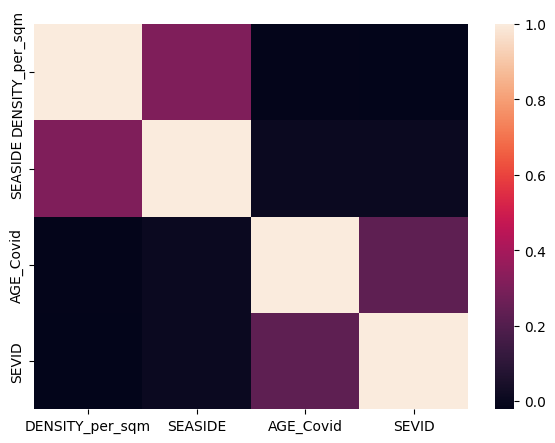

In [11]:
# Generating the correlating matrix
df_fs_heat = df_fs.drop(['LAT', 'LON', 'Ventilation', 'Medications',
       'inpatient', 'Disorder', 'Death'], axis = 1)
corr = df_fs_heat.corr()

plt.figure(figsize=(7, 5))
# Generating the correlation heat-map
sns.heatmap(corr, annot=False)

In [12]:
#Generating Map

Map_Coordinates=(42.40, -71.38)
map_ma = folium.Map(location = Map_Coordinates, width = "100%", zoom_start = 8)
coordinates = df_fs[["LAT", "LON"]].values.tolist()
for i in range (0, len(coordinates)):
  folium.RegularPolygonMarker(coordinates[i], radius = 0.5, fill_color = "blue").add_to(map_ma)
map_ma